In [14]:
import os
import tensorflow as tf
import numpy as np
from glob import glob
from keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Flatten
from keras.models import Model
from keras.optimizers import Adam

In [15]:
tf.__version__

'2.18.0'

In [16]:
# Paramètres
IMG_WIDTH, IMG_HEIGHT = 224, 224  # Taille des images
BATCH_SIZE = 32
DATA_DIR = "archive\CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone\CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone"  # Chemin vers votre dossier de données

# Création des générateurs de données
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalisation des pixels
    validation_split=0.2  # Fraction des données pour la validation
)

train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # Pour la classification multiclasse
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

<>:4: SyntaxWarning: invalid escape sequence '\C'
<>:4: SyntaxWarning: invalid escape sequence '\C'
C:\Users\HP\AppData\Local\Temp\ipykernel_10428\4131103201.py:4: SyntaxWarning: invalid escape sequence '\C'
  DATA_DIR = "archive\CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone\CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone"  # Chemin vers votre dossier de données


Found 9959 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


In [17]:
print(train_generator.class_indices)

{'Cyst': 0, 'Normal': 1, 'Stone': 2, 'Tumor': 3}


In [18]:
#Préparer le modèle de base
img_shape=(224,224,3)
base_model=VGG16(input_shape=img_shape,include_top=False,weights="imagenet")
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
base_model.trainable=False

In [20]:
# Ajouter les couches sorties
x=Flatten()(base_model.output)
prediction=Dense(units=4,activation="softmax")(x)

In [21]:
# Création du modèle global
model=Model(inputs=base_model.input,outputs=prediction)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │       100,356 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,815,044 (56.51 MB)

 Trainable params: 100,356 (392.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [22]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [23]:
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset='training'
)

test_generator = test_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset='validation'
)

Found 12446 images belonging to 4 classes.
Found 0 images belonging to 4 classes.


In [24]:

# Check the number of classes
num_classes = len(train_generator.class_indices)
print(f"Number of classes: {num_classes}")

# Update the model if necessary
if num_classes != 4:
	x = Flatten()(base_model.output)
	prediction = Dense(units=num_classes, activation="softmax")(x)
	model = Model(inputs=base_model.input, outputs=prediction)
	model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Entraîner le modèle
history = model.fit(train_generator, epochs=2, validation_data=validation_generator)

# Évaluer le modèle
loss, accuracy = model.evaluate(validation_generator)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

Number of classes: 4


c:\Users\HP\Documents\Transfert_learning\transfert\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/2
389/389 ━━━━━━━━━━━━━━━━━━━━ 3761s 10s/step - accuracy: 0.7450 - loss: 0.7974 - val_accuracy: 0.9863 - val_loss: 0.0796
Epoch 2/2
389/389 ━━━━━━━━━━━━━━━━━━━━ 3925s 10s/step - accuracy: 0.9773 - loss: 0.1065 - val_accuracy: 0.9948 - val_loss: 0.0436
78/78 ━━━━━━━━━━━━━━━━━━━━ 643s 8s/step - accuracy: 0.9936 - loss: 0.0486
Loss: 0.043640874326229095
Accuracy: 0.9947727918624878


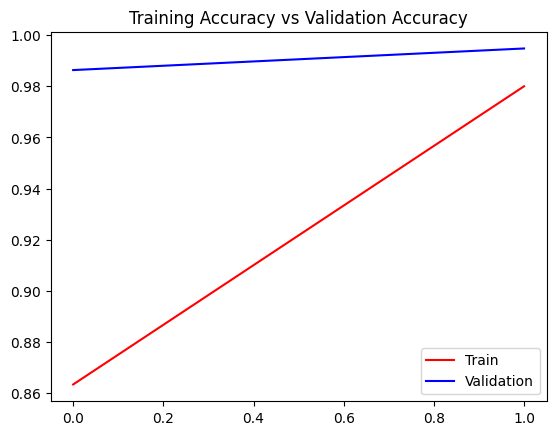

In [25]:
from matplotlib import pyplot as plt    

plt.title('Training Accuracy vs Validation Accuracy')

plt.plot(history.history['accuracy'], color='red',label='Train')
plt.plot(history.history['val_accuracy'], color='blue',label='Validation')

plt.legend()

In [26]:
# Prédiction d'une image
def predict_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalisation des pixels

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)
    class_labels = list(train_generator.class_indices.keys())
    predicted_label = class_labels[predicted_class[0]]

    return predicted_label

# Exemple d'utilisation
image_path = 'test.jpg'  # Define the image path
predicted_label = predict_image(image_path)
print(f"Predicted label: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
Predicted label: Stone


In [27]:
# Ensure that CELL INDEX 10 is executed before this cell
model.save('model.h5')
print("Model saved as model.h5")

Model saved as model.h5
